In [1]:
# import project directory helper
import os, sys
ROOT_DIR = os.path.abspath('/home/hduser/document/jupyter/FYP/') 
sys.path.insert(0, ROOT_DIR)

In [2]:
# import pyspark packages
# from pyspark import SparkContext
# from pyspark.sql import SQLContext
# set the kafka dependencies before create spark context or session
# import os
# os.environ[
#     'PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.4,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.4 pyspark-shell'
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.types import *

In [3]:
# import util packages
from IPython.display import display
import pandas as pd

In [4]:
spark = SparkSession.builder.appName('attraction').getOrCreate()
spark

In [5]:
# define path
ds_dir = ROOT_DIR + '/crawler/datasets/tripadvisor_dataset/attractions/'
spark_warehouse_dir = ROOT_DIR + '/crawler/datasets/tripadvisor_dataset/attractions/spark-warehouse/'

In [6]:
# define path
ds_dir = ROOT_DIR + '/crawler/datasets/tripadvisor_dataset/attractions/'
spark_warehouse_dir = ROOT_DIR + '/crawler/datasets/tripadvisor_dataset/attractions/spark-warehouse/'

In [7]:
# read spark dataframe from parquet
attr_review_spark_df = spark.read.parquet(ds_dir + 'tripad_attr_review').repartition(160)
attr_review_spark_df.count()

7146

In [8]:
attr_review_spark_df = attr_review_spark_df.select(
    attr_review_spark_df.activityId.cast("string"), attr_review_spark_df.rating,
    attr_review_spark_df.text.alias('review'),
    attr_review_spark_df.publishedDate.alias('review_date'),
    attr_review_spark_df.username.alias('user'), attr_review_spark_df.userId)

In [9]:
attr_review_df = attr_review_spark_df.toPandas()
attr_review_df['user_id'] = attr_review_df.index

In [10]:
display(attr_review_df)

,activityId,rating,review,review_date,user,userId,user_id
0,11449677,4,Very good Bus tour with a great guide/speaker ...,2018-02-12,Vincent W,BB0401B4A7E786BCB80F6A34F9CA7CD5,0
1,12880465,5,This was our second visit to KL and we had tic...,2018-10-19,DarrenCBristol,37060EBD1EB824EBB6E8E70215D27C70,1
2,16722683,5,Cheap way to see main highlights of KL. Hop on...,2016-10-27,BudiMohdYunus,08C1EDB33313D195676C1334F800272C,2
3,12468919,5,"Zoo is not my usual favourite, but I must say ...",2018-09-29,amyrosylily,7048960540A76440C6BCA16D4B0D649B,3
4,12650625,5,It was an enjoyable ride with great scenary wi...,2019-06-07,LakeGardenEcoRide,27721A880DA255F34D797EDAF03D28E5,4
5,11454341,5,We booked the jet skiing experience the day be...,2018-02-10,alic1988,3D56FCDC833D0F6E4CE6410A56964CB9,5
6,16722683,5,We went in the hop on off bus on a very hot da...,2016-09-29,Bubbles W,1BC5DBF5897A853A5A3A7F06B1D60B44,6
7,16722683,2,Having travelled on a number of Hop on Hop off...,2015-05-18,rhondda1,07972311330CF222252B246D4E8DE087,7
8,12943485,5,Its was very challenging and fun! The staff ar...,2019-10-08,njlaaaa,08538AF0DDAE4466DA16EBC29ABC32F0,8
9,17404880,4,Had a lot of fun even for first timer ! Suitab...,2019-10-07,Zettyzulkifli,89EC1E138DAEBFF018D741F86CD84260,9


# Sentiment Analysis using RNN with LSTM

There are different ways of building a neural network. One of the more complicated architectures, which is known to perform very well on text data, is the Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM). RNNs are designed to learn from sequences of data, where there is some kind of time dependency. For example, they are used for time-series analysis, where each data point has some relation to those immediately before and after. By extension, they work very well for language data, where each word is related to those before and after it in a sentence.

In [13]:
from collections import Counter
from datetime import datetime

import json

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np

Using TensorFlow backend.


To load the reviews from disk, run the following in the next cell:

Each review in the tripadvisor attraction dataset contains the text of the review and the associated star rating, left by the reviewer. Our task is to teach a classifier to differentiate between positive and negative reviews, looking only at the review text itself.

It is very important to have a balanced dataset for supervised learning. This means that we want the same amount of positive and negative reviews when we train our neural network to tell the difference between them. If we have more positive reviews than negative reviews, the network will learn that most reviews are positive, and adjust its predictions accordingly. We’ll, therefore, take a sample of the tripadvisor attraction reviews which contains the same amount of positive (four or five-star reviews) and negative (one, two, or three-star reviews)

In [39]:
import json
reviews = attr_review_df.to_dict(orient='records')

In [40]:
text_list = [review['review'] for review in reviews]

# Convert our 5 classes into 2 (negative or positive)
binstars = [0 if review['rating'] <= 3 else 1 for review in reviews]
trained_texts = []
trained_labels = []
limit = 100000  # Change this to grow/shrink the dataset
neg_pos_counts = [0, 0]
for i in range(len(text_list)):
    polarity = binstars[i]
    if neg_pos_counts[polarity] < limit:
        trained_texts.append(text_list[i])
        trained_labels.append(binstars[i])
        neg_pos_counts[polarity] += 1

This gets 100000 positive and 100000 negative reviews. If we use less data, we’ll get significantly worse accuracy, as neural networks usually need a lot of data to train well. More data will result in longer training times for our neural network.

# Tokenizing the texts

Keras represents each word as a number, with the most common word in a given dataset being represented as 1, the second most common as a 2, and so on. This is useful because we often want to ignore rare words, as usually, the neural network cannot learn much from these, and they only add to the processing time. If we have our data tokenized with the more common words having lower numbers, we can easily train on only the N most common words in our dataset, and adjust N as necessary (for larger datasets, we would want a larger N, as even comparatively rare words will appear often enough to be useful).

Tokenization in Keras is a two step process. First, we need to calculate the word frequencies for our dataset (to find the most common words and assign these low numbers). Then we can transform our text into numerical tokens. The calculation of the word frequencies is referred to as ‘fitting’ the tokenizer, and Keras calls the numerical representations of our texts ‘sequences’.

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(trained_texts)
sequences = tokenizer.texts_to_sequences(trained_texts)
data = pad_sequences(sequences, maxlen=300)

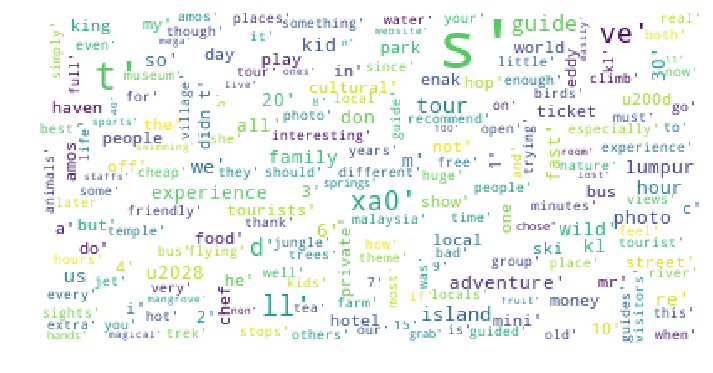

In [43]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize'] = (12.0, 10.0)  #(6.0,4.0)
mpl.rcParams['font.size'] = 12  #10
mpl.rcParams['savefig.dpi'] = 100  #72
mpl.rcParams['figure.subplot.bottom'] = .1

text = tokenizer.word_index

stopwords = set(STOPWORDS)
data = text

wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=200,
                      max_font_size=40,
                      random_state=42).generate(str(data))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# Creating Neural network model

One of the more complicated architectures, which is known to perform very well on text data, is the Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM). RNNs are designed to learn from sequences of data, where there is some kind of time dependency. For example, they are used for time-series analysis, where each data point has some relation to those immediately before and after. By extension, they work very well for language data, where each word is related to those before and after it in a sentence.

When we use more layers the accuracy gets slightly worse, but the execution gets there much faster.

In [48]:
data

{'the': 1,
 'and': 2,
 'to': 3,
 'a': 4,
 'was': 5,
 'we': 6,
 'of': 7,
 'in': 8,
 'for': 9,
 'i': 10,
 'it': 11,
 'is': 12,
 'you': 13,
 'tour': 14,
 'with': 15,
 'on': 16,
 'this': 17,
 'our': 18,
 'very': 19,
 'at': 20,
 'us': 21,
 'were': 22,
 'as': 23,
 'that': 24,
 'so': 25,
 'had': 26,
 'but': 27,
 'great': 28,
 'not': 29,
 'are': 30,
 'time': 31,
 'all': 32,
 'have': 33,
 'my': 34,
 'he': 35,
 'guide': 36,
 'from': 37,
 'day': 38,
 'there': 39,
 'about': 40,
 'be': 41,
 'experience': 42,
 'an': 43,
 'good': 44,
 'would': 45,
 'up': 46,
 'they': 47,
 'kl': 48,
 'food': 49,
 'if': 50,
 'get': 51,
 'trip': 52,
 'one': 53,
 'recommend': 54,
 'bus': 55,
 'really': 56,
 'see': 57,
 'which': 58,
 'also': 59,
 'by': 60,
 'some': 61,
 'do': 62,
 'way': 63,
 'can': 64,
 'off': 65,
 'well': 66,
 'city': 67,
 'out': 68,
 'more': 69,
 'will': 70,
 'just': 71,
 'around': 72,
 'your': 73,
 'only': 74,
 'back': 75,
 'amazing': 76,
 'fun': 77,
 'when': 78,
 'much': 79,
 'or': 80,
 'did': 81,
 '

In [93]:
np.array([data])

array([{'the': 1, 'and': 2, 'to': 3, 'a': 4, 'was': 5, 'we': 6, 'of': 7, 'in': 8, 'for': 9, 'i': 10, 'it': 11, 'is': 12, 'you': 13, 'tour': 14, 'with': 15, 'on': 16, 'this': 17, 'our': 18, 'very': 19, 'at': 20, 'us': 21, 'were': 22, 'as': 23, 'that': 24, 'so': 25, 'had': 26, 'but': 27, 'great': 28, 'not': 29, 'are': 30, 'time': 31, 'all': 32, 'have': 33, 'my': 34, 'he': 35, 'guide': 36, 'from': 37, 'day': 38, 'there': 39, 'about': 40, 'be': 41, 'experience': 42, 'an': 43, 'good': 44, 'would': 45, 'up': 46, 'they': 47, 'kl': 48, 'food': 49, 'if': 50, 'get': 51, 'trip': 52, 'one': 53, 'recommend': 54, 'bus': 55, 'really': 56, 'see': 57, 'which': 58, 'also': 59, 'by': 60, 'some': 61, 'do': 62, 'way': 63, 'can': 64, 'off': 65, 'well': 66, 'city': 67, 'out': 68, 'more': 69, 'will': 70, 'just': 71, 'around': 72, 'your': 73, 'only': 74, 'back': 75, 'amazing': 76, 'fun': 77, 'when': 78, 'much': 79, 'or': 80, 'did': 81, 'me': 82, 'go': 83, 'took': 84, 'friendly': 85, 'no': 86, 'visit': 87, 'bes

In [95]:
model = Sequential()

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(np.array(data), np.array(trained_labels), validation_split=0.5, epochs=3)
# model.predict(data, np.array(trained_labels))

In [103]:
trained_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,


In [83]:
print(model.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 300, 128)          1280000   
_________________________________________________________________
dropout_33 (Dropout)         (None, 300, 128)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 296, 64)           41024     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 74, 64)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 1,419,969
Trainable params: 1,419,969
Non-trainable params: 0
___________________________________________